In [1]:
import hyperspy.api as hs
import numpy as np

from utils.getting_spectral_lines_from_hspy import get_spesific_lines_from_hspy
from utils.get_raw_data import locate_raw_data, get_multiple_data_arrays
from utils.helper_plotting import plotly_plot_multiple_spectra

# functions imported from helper_files
from helper_files.plotting import plot_lines, plotly_plot
from helper_files.gaussian_fitting import (
    gaussian,
    n_gaussians,
    fit_n_peaks_to_gaussian,
    area_under_peak,
)
from helper_files.calibration import calibrate_channel_width_two_peaks, channel_to_keV
from helper_files.spectrum_dict import init_known_spectrum

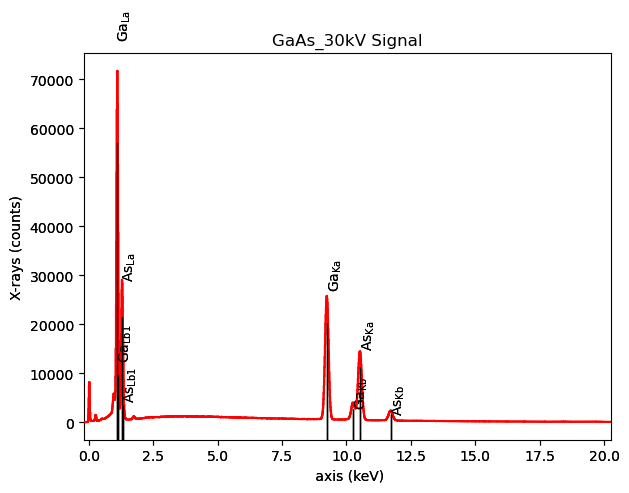

In [2]:
# plot matlpotlib in separate window
# %matplotlib qt
emsa = locate_raw_data()
ga30 = get_multiple_data_arrays(filters=["GaAs_30"])
s = hs.load(emsa[7], signal_type="EDS_SEM")
s.add_elements(["Ga", "As"])
s.plot(True)


In [3]:
ga05 = get_multiple_data_arrays(filters=["GaAs_05"])

In [4]:
ga30[0][1]

array([0.        , 0.        , 0.        , ..., 0.00078112, 0.00085086,
       0.00072533])

In [5]:
print(ga30)

[['GaAs_30kV', array([0.        , 0.        , 0.        , ..., 0.00078112, 0.00085086,
       0.00072533])]]


In [6]:
# count sum from 120 to 160
ga30 = get_multiple_data_arrays(filters=["GaAs_30"], normalize=False)
np.array(ga30[0][1][120:160]).sum()

840420.0

In [7]:
ga05 = get_multiple_data_arrays(filters=["GaAs_05"], normalize=False)
np.array(ga05[0][1][120:160]).sum()

742736.0

In [8]:
# count sum from 120 to 160
ga30 = get_multiple_data_arrays(filters=["GaAs_30"])
np.array(ga30[0][1][120:160]).sum()

11.722646878312784

In [9]:
ga05 = get_multiple_data_arrays(filters=["GaAs_05"])
np.array(ga05[0][1][120:160]).sum()

15.134403781889315

In [10]:
ga30

[['GaAs_30kV',
  array([0.        , 0.        , 0.        , ..., 0.00078112, 0.00085086,
         0.00072533])]]

In [11]:
hs.material.elements['Ga'].Atomic_properties.Xray_lines.as_dictionary()

{'Lb1': {'weight': 0.16704, 'energy (keV)': 1.1249},
 'Kb': {'weight': 0.1287, 'energy (keV)': 10.2642},
 'Ka': {'weight': 1.0, 'energy (keV)': 9.2517},
 'La': {'weight': 1.0, 'energy (keV)': 1.098},
 'Ln': {'weight': 0.02509, 'energy (keV)': 0.9842},
 'Ll': {'weight': 0.0544, 'energy (keV)': 0.9573},
 'Lb3': {'weight': 0.0461, 'energy (keV)': 1.1948}}

In [12]:
hs.material.elements['As'].Atomic_properties.Xray_lines.as_dictionary()

{'Lb1': {'weight': 0.16704, 'energy (keV)': 1.3174},
 'Kb': {'weight': 0.14589, 'energy (keV)': 11.7262},
 'Ka': {'weight': 1.0, 'energy (keV)': 10.5436},
 'La': {'weight': 1.0, 'energy (keV)': 1.2819},
 'Ln': {'weight': 0.01929, 'energy (keV)': 1.1551},
 'Ll': {'weight': 0.04929, 'energy (keV)': 1.1196},
 'Lb3': {'weight': 0.04769, 'energy (keV)': 1.386}}

In [13]:
s = init_known_spectrum(
    name="GaAs at 30kV",
    filepath=emsa[7],
    start_str="#SPECTRUM    : Spectral Data Starts Here",
    stop_str="#ENDOFDATA   : ",
    line_endings="\n",
    delimiter=", ",
    # calibrate on Ga_La and As_Ka
    # peaks_keV=[1.098, 9.2517, 10.2642],
    peaks_keV=[1.098, 10.5436],

    peaks_names=['Ga L&#945;</sub>', 'As K&#945;</sub>'],
    # peaks_names=[Ga_La, 'As_Ka'],

    peaks_channel=[131, 1072],
)

Reading C:\Users\Brynjar\Documents\Masteroppgave\2022-09-06_EDS-Apreo\exports\GaAs_30kV.emsa
The first line looks like this: '#FORMAT      : EMSA/MAS Spectral Data File\n'
Reading from line 42 to 2091.
2048 data points, first entry = [-0.2, 0.0], last entry = [20.27, 52.0]



In [16]:
fig_intitial = plotly_plot(
    x=s["channel"],
    y=s["intensity"],
    title=s["name"],
    xaxis_title="channel",
    yaxis_title="intensity",
)
# fig_intitial.show()
'init'

'init'

In [17]:
# fitting

fit_vals = fit_n_peaks_to_gaussian(
    x=s["channel"],
    y=s["intensity"],
    guessed_peaks=s["peaks_channel"],
)
s["fit_params"] = fit_vals[0]
s["fit_cov"] = fit_vals[1]
# update the channel values of the peaks
s["peaks_channel"] = s["fit_params"][1::3]
# addin the fitted gaussian to the spectrum-dictionary
s["intensity_fit"] = n_gaussians(s["channel"], *fit_vals[0])

print(f'Fitted peaks at channel: {s["peaks_channel"]}')


Fitted peaks at channel: [ 130.56740439 1071.93843772]


In [20]:
fig_fit = plotly_plot(
    s["channel"],
    s["intensity"],
    y_fit=s["intensity_fit"],
    vlines=s["peaks_channel"],
    vlines_name=s["peaks_names"],
    title=f"Gaussian fitting of {s['name']}",
)
fig_fit = plotly_plot(x=s['channel'], fig=fig_fit, fit_params=s['fit_params'], title=f"Gaussian fitting of {s['name']}")
# fig_fit.show()

calib = calibrate_channel_width_two_peaks(s["peaks_channel"], s["peaks_keV"])
s["dispersion"] = calib[0]
s["offset"] = calib[1]
s["kev_calibrated"] = (s["channel"] - s["offset"]) * s["dispersion"]

The calibration factor is: 0.0100339 keV/channel, with 21.138 channels zero offset


In [22]:
print("Peak name | Peak position (mu) [keV] | Peak amplitude (a) | FWHM (std*2*sqrt(2*ln(2))) [keV] | Area under peak")
for i in range(len(s["fit_params"]) // 3):
    try:
        peak_name = s["peaks_names"][i]
    except (
        IndexError,
        TypeError,
    ):  # if s['peaks_names'] is None or not as long as the number of peaks
        peak_name = f"peak {i}"
    mu = channel_to_keV(s, value=s['fit_params'][i*3+1])
    amp = s['fit_params']
    fwhm = channel_to_keV(s, value=s['fit_params'][i * 3 + 2] * 2 * (np.log(2) * 2)**0.5, use_offset=False)
    area = area_under_peak(s['fit_params'][i*3+1], s['fit_params'][2 + 3 * i], s['fit_params'][3 * i])
    print(f"{peak_name:<9} | {mu:<24.4f} | {amp[i*3]:<18.4f} | {fwhm:<32.4f} | {area:.6f}")


s["peaks_keV_fitted"] = channel_to_keV(s, value=s['peaks_channel'])

# for plotting Ga Ka with theoretical Ga Ka1 and Ga Ka2
vertical_lines = [s["peaks_keV_fitted"][0], 9.25174, 9.22482]
vertical_lines_names = [s["peaks_names"][0], 'Ga K&#945;<sub>1</sub>', 'Ga K&#945;<sub>2</sub>' ]

fig_calib = plotly_plot(
x=s["kev_calibrated"],
y_named=[s["intensity"], "intensity"],
vlines=vertical_lines,
vlines_name=vertical_lines_names,
title=s['name'],
xaxis_title="Energy [keV]",
start=925, #  index
stop=964, #  index
)

fig_calib.update_layout(yaxis_range=[-0.025,0.4])
fig_calib.update_layout(showlegend=False)

'final'
# fig_calib.show()
# fig_calib.write_html("../plots/GaAs30kV-Ga-K-lines.html")

Peak name | Peak position (mu) [keV] | Peak amplitude (a) | FWHM (std*2*sqrt(2*ln(2))) [keV] | Area under peak
Ga L&#945;</sub> | 1.0980                   | 0.9979             | 0.0750                           | 0.995223
As K&#945;</sub> | 10.5436                  | 0.1931             | 0.1947                           | 0.192606


'final'